# Imports and loading df

In [1]:
#!pip install transformers
#!pip install transformers tensorflow
#needed for bert

In [2]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
#import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

#from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import unicodedata
import random
from sklearn.model_selection import GridSearchCV

from transformers import BertTokenizer, BertModel
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
df = pd.read_csv("../data/brand_product_emotion.csv", encoding= 'unicode_escape')

In [4]:
sw = stopwords.words('english')

In [5]:
#following 2 functions taken from class
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:
#to remove non-english text, these tweets contain a lot of weird shit like "Ï¡Ïàü_ÊÎÒ£Áââ_£â_"
#what the fuck even is that lmao
def remove_non_english_chars(text):
    return ''.join(ch for ch in text if unicodedata.category(ch)[0] in ['L', 'N', 'P'] or ch.isspace())
    #return ''.join(ch if unicodedata.category(ch)[0] in ['L', 'P'] or ch.isspace() else '' for ch in text)

In [7]:
def doc_preparer(doc, stop_words=sw):
    #regex_token = RegexpTokenizer(r"(?:\b[a-zA-Z#']+\b|\b\w+(?:['’]\w+)?|[^\w\s\p{P}]+|:\w+)")
    # above should work, maybe on more updated environment?
    #regex_token = RegexpTokenizer(r"(?:\b[a-zA-Z#']+\b|\b\w+(?:['’]\w+)?|[^\w\s]+|:\w+)")
    # above was supposed to ignore weird characters n shit but didnt
    
    #regex_pattern = r"(?:\b[a-zA-Z#']+\b|\b\w+(?:['’]\w+)?|[^\w\s]+|:\w+|\@\w+)"
#===========================================================================
#everything bewtween these lines is the legacy doc_prep. keeping the legacy incase the new one doesnt work.
    #regex_pattern = r"(?:\b[a-zA-Z]+(?:'[a-zA-Z]+)?\b|\@\w+|\#\w+|[^\w\s]+)"
    #regex_token = RegexpTokenizer(regex_pattern)
    
    #doc = regex_token.tokenize(doc)

    #doc = [word.lower() for word in doc]
    #doc = [word for word in doc if word not in sw]

    #doc = pos_tag(doc)
    #doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    #lemmatizer = WordNetLemmatizer() 
    #doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    #return ' '.join(doc)
#================================================================================
    #doc = remove_non_english_chars(doc)
    regex_pattern = r"(?:\b[a-zA-Z]+(?:'[a-zA-Z]+)?\b|\@\w+|\#\w+|[^\w\s]+)"
    regex_token = RegexpTokenizer(regex_pattern)
    
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

## Cleaning up db a bit

In [8]:
new_col_names = {'tweet_text': 'tweet', 
                 'emotion_in_tweet_is_directed_at':'brand_product', 
                 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}
df = df.rename(columns=new_col_names)

In [9]:
df['emotion'] = df['emotion'].replace("Positive emotion","positive")
df['emotion'] = df['emotion'].replace("Negative emotion","negative")
df['emotion'] = df['emotion'].replace("No emotion toward brand or product","neutral")
df['emotion'] = df['emotion'].replace("I can't tell","unknown")

In [10]:
emotion_map = {'neutral': 0, 'positive': 1, 'negative': 2, 'unknown':3}
df['target'] = df['emotion'].map(emotion_map)

In [11]:
df.drop('emotion', axis = 1, inplace = True)
#df.drop('device', axis = 1, inplace = True)

In [12]:
df['tweet'] = df['tweet'].fillna('unknown')

In [13]:
#df['tweet'].dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          9093 non-null   object
 1   brand_product  3291 non-null   object
 2   target         9093 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 213.2+ KB


Will leave preprocessing step for during the pipe/modeling so we can apply this to all incoming tweets

In [14]:
# create new db to use to drop the value of 3 in target. 3 is the unknown tag, will not help in training model
# 0 is neutral
# 1 is positive
# 2 is negative
df_touse = df[df['target']!= 3]

# Begin base model with class provided text-processer
- regex will be filtering out unknown characters and keep hashtags and emoticons (such as :D)
- example: 
    - ŒÏ¡ŽÏàŠü_‹Ê‹Î‹Ò‹£‹Á‹ââ‹_‹£‹‹â_‹ÛâRT @mention Google Tests ‰ÛÏCheck-in Offers‰Û At #SXSW {link}
    - becomes
    - ['RT', '@mention', 'Google', 'Tests', 'Check-in', 'Offers', 'At', '#SXSW', '{link}']

In [15]:
df_touse['processed_text'] = df_touse['tweet'].apply(remove_non_english_chars)

<ipython-input-15-1371a65b0e8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_touse['processed_text'] = df_touse['tweet'].apply(remove_non_english_chars)


In [16]:
df_touse['processed_text'] = df_touse['processed_text'].apply(doc_preparer)

<ipython-input-16-4e1ac35fa161>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_touse['processed_text'] = df_touse['processed_text'].apply(doc_preparer)


In [17]:
df_touse

,tweet,brand_product,target,processed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,2,".@ iphone . hr tweet #rise_austin , dead ! nee..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know @fludapp ? awesome ipad / iphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin wait #ipad also . sale #sxsw .
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,2,@sxsw hope year's festival crashy year's iphon...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff fri #sxsw : marissa may...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,1,ipad everywhere . #sxsw { link }
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,0,"wave , buzz ... rt @mention interrupt regularl..."
9090,"Google's Zeiger, a physician never reported po...",NaN,0,"google's zeiger , physician never report poten..."
9091,Some Verizon iPhone customers complained their...,NaN,0,verizon iphone customer complain time fell bac...


In [18]:
#t-t-s
X = df_touse['processed_text']
y = df_touse['target']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

### First model, using countvect and mnb.

In [19]:
fullpipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [20]:
#train model
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])

In [21]:
#predict sentiment on test set
y_pred = fullpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.79      0.76      1095
           1       0.53      0.51      0.52       571
           2       0.52      0.13      0.21       122

    accuracy                           0.66      1788
   macro avg       0.59      0.48      0.50      1788
weighted avg       0.65      0.66      0.65      1788



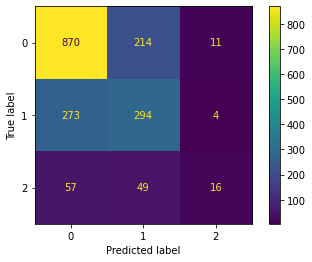

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### 2nd model, using tfidf and mnb

In [23]:
fullpipe = Pipeline([
    ('tdidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [24]:
#train model
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [25]:
#predict sentiment on test set
y_pred = fullpipe.predict(X_test)

In [26]:
#eval model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.94      0.78      1095
           1       0.68      0.27      0.39       571
           2       0.00      0.00      0.00       122

    accuracy                           0.67      1788
   macro avg       0.45      0.41      0.39      1788
weighted avg       0.62      0.67      0.60      1788



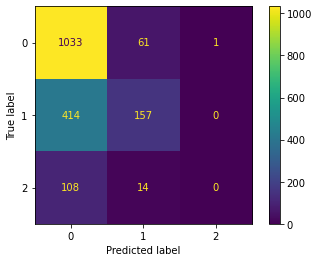

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Conclusion for these 2 models:
- Man tfidf sucks. May be because we are keeping many repeated words such as sxsw, mention, and link and rt. The following iterations will change the preprocessing functions a bit.

### Begin model 3
- doing tfidf and count vectorizer again to see if anything changes

In [28]:
def doc_preparer(doc, stop_words=sw):
    regex_pattern = r"(?:\b[a-zA-Z]+(?:'[a-zA-Z]+)?\b|\@\w+|\#\w+|[^\w\s]+)"
    regex_token = RegexpTokenizer(regex_pattern)
    
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc if word.lower() not in ["#sxsw", "@mention", "{link}", "rt"]]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [29]:
df_touse['processed_text'] = df_touse['tweet'].apply(remove_non_english_chars)
df_touse['processed_text'] = df_touse['processed_text'].apply(doc_preparer)
df_touse

<ipython-input-29-6bae6bdbaeb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_touse['processed_text'] = df_touse['tweet'].apply(remove_non_english_chars)
<ipython-input-29-6bae6bdbaeb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_touse['processed_text'] = df_touse['processed_text'].apply(doc_preparer)


,tweet,brand_product,target,processed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,2,".@ iphone . hr tweet #rise_austin , dead ! nee..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know @fludapp ? awesome ipad / iphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin wait #ipad also . sale .
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,2,@sxsw hope year's festival crashy year's iphon...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff fri : marissa mayer ( g...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,1,ipad everywhere . { link }
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,0,"wave , buzz ... interrupt regularly schedule g..."
9090,"Google's Zeiger, a physician never reported po...",NaN,0,"google's zeiger , physician never report poten..."
9091,Some Verizon iPhone customers complained their...,NaN,0,verizon iphone customer complain time fell bac...


In [30]:
#t-t-s
X = df_touse['processed_text']
y = df_touse['target']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

### Model 3 Count Vect:

In [31]:
fullpipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [32]:
#train model
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])

In [33]:
#predict sentiment on test set
y_pred = fullpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1095
           1       0.52      0.52      0.52       571
           2       0.56      0.15      0.23       122

    accuracy                           0.65      1788
   macro avg       0.60      0.48      0.50      1788
weighted avg       0.64      0.65      0.64      1788



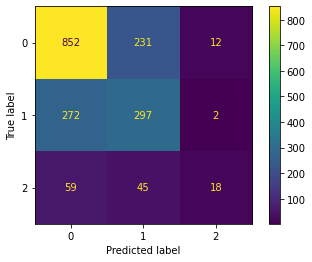

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Model 4 tfidf

In [35]:
fullpipe = Pipeline([
    ('tdidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [36]:
#train model
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [37]:
#predict sentiment on test set
y_pred = fullpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1095
           1       0.68      0.28      0.40       571
           2       0.00      0.00      0.00       122

    accuracy                           0.67      1788
   macro avg       0.45      0.41      0.39      1788
weighted avg       0.62      0.67      0.61      1788



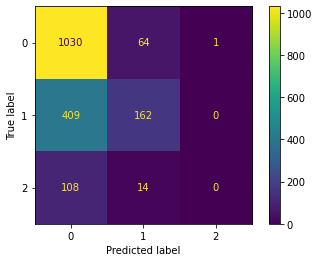

In [38]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Conclusion after model 3 and 4
- alright so tfidf cant figure out negative emotions. Will ignore tfidf for now and just rely on countvect

### Gridsearching CountVectorizer and MNB model 5:

In [39]:
fullpipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [40]:
parameters = {
    'cv__max_features': [5000, 10000, 20000],  # Number of features to consider
    'cv__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams to generate
    'mnb__alpha': [0.1, 1.0, 10.0]  # Smoothing parameter for MultinomialNB
}
# Define the grid search
grid_search = GridSearchCV(fullpipe, parameters, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

bestpipe = grid_search.best_estimator_

Best Parameters:  {'cv__max_features': 20000, 'cv__ngram_range': (1, 2), 'mnb__alpha': 1.0}
Best Score:  0.6758965876670565


              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1095
           1       0.52      0.54      0.53       571
           2       0.54      0.16      0.24       122

    accuracy                           0.65      1788
   macro avg       0.59      0.49      0.51      1788
weighted avg       0.65      0.65      0.64      1788



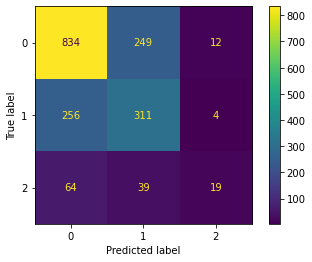

In [41]:
#predict sentiment on test set
y_pred = bestpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

- A lil better, will try more parameters

### Model 6 Count vect and mnb

In [42]:
parameters = {
    'cv__max_features': [20000,25000,30000],  # Number of features to consider
    'cv__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams to generate
    'mnb__alpha': [0.1, 1.0, 10.0]  # Smoothing parameter for MultinomialNB
}
# Define the grid search
grid_search = GridSearchCV(fullpipe, parameters, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

bestpipe = grid_search.best_estimator_

Best Parameters:  {'cv__max_features': 30000, 'cv__ngram_range': (1, 2), 'mnb__alpha': 1.0}
Best Score:  0.6792544054965328


              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1095
           1       0.54      0.52      0.53       571
           2       0.63      0.16      0.25       122

    accuracy                           0.66      1788
   macro avg       0.63      0.49      0.51      1788
weighted avg       0.65      0.66      0.65      1788



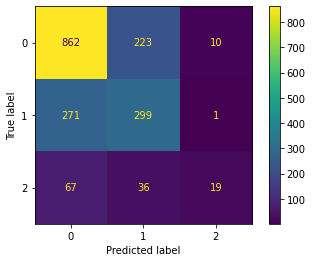

In [43]:
#predict sentiment on test set
y_pred = bestpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Model 7
- conclusion from above: well true 1 label got a bit worse, true 0 label sig improved.
- Assuming increasing max_features will improve true 0 labeling at the cost of true 1 labeling

In [44]:
parameters = {
    'cv__max_features': [30000, 35000,40000],  # Number of features to consider
    'cv__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams to generate
    'mnb__alpha': [1, 1.1, 1.2, 1.5]  # Smoothing parameter for MultinomialNB
}
# Define the grid search
grid_search = GridSearchCV(fullpipe, parameters, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

bestpipe = grid_search.best_estimator_

Best Parameters:  {'cv__max_features': 30000, 'cv__ngram_range': (1, 2), 'mnb__alpha': 1.1}
Best Score:  0.6799534125776253


              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1095
           1       0.54      0.51      0.53       571
           2       0.63      0.16      0.25       122

    accuracy                           0.66      1788
   macro avg       0.63      0.49      0.51      1788
weighted avg       0.66      0.66      0.65      1788



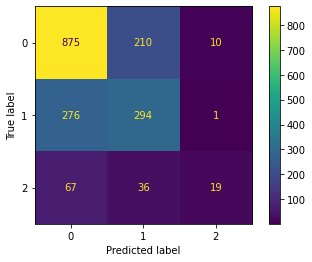

In [45]:
#predict sentiment on test set
y_pred = bestpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Conclusion:
- nop, looks like iteration 6 was the best parameters.
- To be honest this model is still ass. 
-  I want to explore other vectorizing methods. Will try using BERT for vectorization

In [46]:
#load bert
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [47]:
#text preprocessing
def preprocess_text(text):
    # Encode text as UTF-8
    encoded_text = text.encode('utf-8')
    # Decode UTF-8 back to string
    decoded_text = encoded_text.decode('utf-8')
    # Tokenize text
    tokens = tokenizer.tokenize(decoded_text)
    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]
    return tokens

In [48]:
def preprocess_text(text):
    # Convert text to lowercase
    text = tf.strings.lower(text)
    # Remove punctuation
    text = tf.strings.regex_replace(text, '[^a-zA-Z0-9]', ' ')
    return text

In [49]:
#since tensorflow doesnt have its own fit_transform, this custom class will provide the needed fit and transform methods
class TextVectorizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, preprocess_fn=None, max_tokens=None):
        self.preprocess_fn = preprocess_fn
        self.max_tokens = max_tokens
        self.vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            standardize=self.preprocess_fn,
            max_tokens=self.max_tokens,
            output_mode='tf-idf'
        )

    def fit(self, X, y=None):
        self.vectorizer.adapt(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer(X).numpy()

In [50]:
fullpipe = Pipeline([
    ('preprocessor', TextVectorizerTransformer(preprocess_text, max_tokens=10000)),
    ('mnb', MultinomialNB())
])

In [51]:
df['tweet'] = df['tweet'].astype('str')
df['target'] = df['target'].astype('float')

In [52]:
df_temp = df_touse

In [53]:
df_temp['tweet'] = df_temp['tweet'].astype('str')
df_temp['target'] = df_temp['target'].astype('float')

<ipython-input-53-1682032b9f33>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['tweet'] = df_temp['tweet'].astype('str')
<ipython-input-53-1682032b9f33>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['target'] = df_temp['target'].astype('float')


In [54]:
X = df_temp['tweet'].tolist()
y = df_temp['target'].tolist()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [56]:
print(type(X_train))
print(X_train[:5])

<class 'list'>
['BEST SWAG EVER. Thanks @mention My charging iPhone thanks you, too. #SXSW {link}', 'Sweet ! @mention RT @mention is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch {link}', 'Yes we were RT @mention Apple store downtown Austin open til Midnight. #sxsw', "#sxsw: @mention Thinks Larry's elevation at Google is great: &quot;lost their way, caring too much about the biz, not enough about the world&quot;", "Receiving a lot of @mention messages telling me I'm sexy in response to my post looking to meet fellow Christian iPhone devs at #sxsw"]


In [57]:
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 TextVectorizerTransformer(max_tokens=10000,
                                           preprocess_fn=<function preprocess_text at 0x000001EAEEFEFCA0>)),
                ('mnb', MultinomialNB())])

              precision    recall  f1-score   support

         0.0       0.78      0.59      0.67      1095
         1.0       0.52      0.58      0.55       571
         2.0       0.27      0.70      0.39       122

    accuracy                           0.59      1788
   macro avg       0.52      0.62      0.53      1788
weighted avg       0.66      0.59      0.61      1788



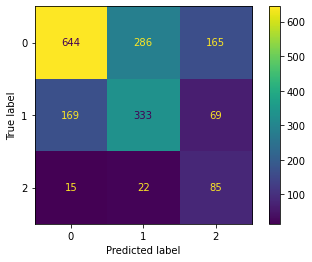

In [58]:
#predict sentiment on test set
y_pred = fullpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Conclusion:
- well bert was a fun side method, but yielded poor results and honestly i dont think its worth going into.

- after meeting with scotty, he had found a way to parse texts and guess which product each tweet was towards and create 5 new cols with an indicator of 0 or 1 if it has that string or not. 

In [59]:
#this code block is to further check the results of the preprocessing
random_index = random.randint(0, len(df) - 1)

random_processed_text = df_touse['processed_text'].iloc[random_index]

tokens = word_tokenize(random_processed_text)

# Display the random sample
print(f"Random Sample (Index: {random_index}) Tokens:")
for token in tokens:
    print(token)
    
print (df_touse['processed_text'].iloc[random_index])
print(df_touse['tweet'].iloc[random_index])

Random Sample (Index: 4582) Tokens:
apple
open
pop
-
store
austin
sxsw
{
link
}
&
lt
;
-
ya
got
ta
hand
apple
...
always
innovate
#
apple
apple open pop - store austin sxsw { link } & lt ;- ya gotta hand apple ... always innovate #apple
Apple Opening Pop-Up Store In Austin For SXSW ~ {link} &lt;- Ya gotta hand it to Apple... always innovating #apple #sxsw
